
# Unsupervised (clustering) learning of netflow logs

In [20]:
# load these packages
from pyspark.ml import feature, regression, evaluation, Pipeline, clustering
from pyspark.sql import functions as fn, Row, SparkSession
from pyspark.sql.functions import col, expr, when
from pyspark.sql.types import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [21]:
#read in the netflow data
netflow = spark.read.csv('netflow_data_final.csv', header=True, inferSchema=True)

In [3]:
netflow.dtypes

[('_c0', 'int'),
 ('dest_ip', 'string'),
 ('dest_port', 'int'),
 ('src_ip', 'string'),
 ('src_port', 'int'),
 ('app', 'string'),
 ('bytes', 'bigint'),
 ('bytes_in', 'int'),
 ('bytes_out', 'int'),
 ('timestamp', 'timestamp'),
 ('endtime', 'timestamp'),
 ('z_score', 'double'),
 ('z_score_class', 'int'),
 ('large_upload', 'int'),
 ('tor_class', 'int'),
 ('private', 'double'),
 ('date', 'timestamp'),
 ('hour', 'int'),
 ('second', 'int'),
 ('bad_traffic', 'int'),
 ('suspicious_traffic', 'int')]

#### Identify the best k (number of clusters) 
Create a vector with assocated features and vectorize it, then convert to dataframe

In [ ]:
from pyspark.ml.feature import VectorAssembler
vector_df = VectorAssembler(inputCols=['z_score', 'large_upload', 'tor_class', 'private'\
                                       , 'bad_traffic', 'suspicious_traffic'], outputCol='features').transform(netflow)

In [ ]:
vector_df.show(1)

#### Create  sample model that will test to see how many clusters best describe the data

In [ ]:
from pyspark.ml.clustering import KMeans
cost = np.zeros(20)  # create numpy array of shape (20,)
for k in range(2,20):  # iterate over 20 iterations of k
    kmeans = KMeans(k=k, seed=1, featuresCol='features')  # create a kmeans object
    model = kmeans.fit(vector_df.sample(False,0.1, seed=42))  # fit the kmeans object to a 10% sample from the dataset 
    cost[k] = model.computeCost(vector_df)

#### Plot the k and the cost to see what the best number of k should be.

In [ ]:
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,20),cost[2:20])
ax.set_xlabel('k')
ax.set_ylabel('cost')

**best k value will be between 5 and 8... will test and cross validate the outputs below**

#### Create a stage of vector with the output called "features", then create a clustering.KMeans stage with the predicted column calle 'kmeans_feat'

In [ ]:
from pyspark.ml.feature import VectorAssembler
kmean_vec = VectorAssembler(inputCols=['z_score', 'large_upload', 'tor_class', 'private'\
                                       , 'bad_traffic', 'suspicious_traffic'], outputCol='features')
kmeans = clustering.KMeans(k=7, featuresCol='features', predictionCol='kmeans_feat')

#### Steps
- 1 Build a pipeline with the stages created above
- 2 fit the dataframe to the pipeline

In [ ]:
#build a pipeline of the stages
pipeline = Pipeline(stages=[kmean_vec, kmeans])

#fit the pipeline to the dataframe
pipeline_model = pipeline.fit(netflow)

In [ ]:
#transform the data to a dataframe
netflow_cluster = pipeline_model.transform(netflow)

#### groupBy the kmeans predicited column to show the cluster breakdown

In [ ]:
netflow_cluster.groupBy("kmeans_feat").count().show()

#### Create a stage of vector with the output called "features", then create a clustering.KMeans stage with the predicted column calle 'kmeans_feat'

In [ ]:
from pyspark.ml.feature import VectorAssembler
kmean_vec = VectorAssembler(inputCols=['z_score', 'large_upload', 'tor_class', 'private'\
                                       , 'bad_traffic', 'suspicious_traffic'], outputCol='features')
kmeans = clustering.KMeans(k=6, featuresCol='features', predictionCol='kmeans_feat')

#### Steps
- 1 Build a pipeline with the stages created above
- 2 fit the dataframe to the pipeline

In [ ]:
#build a pipeline of the stages
pipeline = Pipeline(stages=[kmean_vec, kmeans])

#fit the pipeline to the dataframe
pipeline_model = pipeline.fit(netflow)

In [ ]:
#transform the data to a dataframe
netflow_cluster = pipeline_model.transform(netflow)

#### groupBy the kmeans predicited column to show the cluster breakdown

In [ ]:
netflow_cluster.groupBy("kmeans_feat").count().show()

#### Create a stage of vector with the output called "features", then create a clustering.KMeans stage with the predicted column calle 'kmeans_feat'

In [10]:
from pyspark.ml.feature import VectorAssembler
kmean_vec = VectorAssembler(inputCols=['z_score', 'large_upload', 'tor_class', 'private'\
                                       , 'bad_traffic', 'suspicious_traffic'], outputCol='features')
kmeans = clustering.KMeans(k=5, featuresCol='features', predictionCol='kmeans_feat')

#### Steps
- 1 Build a pipeline with the stages created above
- 2 fit the dataframe to the pipeline

In [11]:
#build a pipeline of the stages
pipeline = Pipeline(stages=[kmean_vec, kmeans])

#fit the pipeline to the dataframe
pipeline_model = pipeline.fit(netflow)

In [12]:
#transform the data to a dataframe
netflow_cluster = pipeline_model.transform(netflow)

#### groupBy the kmeans predicited column to show the cluster breakdown

In [13]:
netflow_cluster.groupBy("kmeans_feat").count().show()

+-----------+-------+
|kmeans_feat|  count|
+-----------+-------+
|          1|1436328|
|          3|      3|
|          4|     39|
|          2|     10|
|          0| 600605|
+-----------+-------+



In [14]:
netflow_cluster_pd = netflow_cluster.select('dest_ip', 'dest_port', 'src_ip', 'src_port', 'app', 'bytes', 'bytes_in', 'bytes_out', 'timestamp', 'endtime', 'z_score', 'z_score_class', 'large_upload', 'tor_class', 'private', 'date', 'hour', 'second', 'bad_traffic', 'suspicious_traffic', 'kmeans_feat')

In [14]:
netflow_cluster_pd.toPandas().to_csv('netflow_cluster.csv')

In [17]:
netflow_cluster_pd.show(1)

+------------+---------+----------+--------+---------+-------+--------+---------+--------------------+--------------------+------------------+-------------+------------+---------+-------+-------------------+----+------+-----------+------------------+-----------+
|     dest_ip|dest_port|    src_ip|src_port|      app|  bytes|bytes_in|bytes_out|           timestamp|             endtime|           z_score|z_score_class|large_upload|tor_class|private|               date|hour|second|bad_traffic|suspicious_traffic|kmeans_feat|
+------------+---------+----------+--------+---------+-------+--------+---------+--------------------+--------------------+------------------+-------------+------------+---------+-------+-------------------+----+------+-----------+------------------+-----------+
|40.97.128.34|      443|10.0.2.109|   58107|office365|1441608|  167497|  1274111|2017-07-31 14:46:...|2017-08-01 01:09:...|0.4627635834505834|            0|           0|        0|    1.0|2017-07-31 00:00:00|  14

### After Testing, k = 5 results is similar clusters compared to k = 6 or k = 7. Will choose k = 5

#### Plot dimensions: 

In [2]:
#convert to pandas
#netflow_cluster_pd = netflow_cluster.toPandas()
netflow_cluster_pd = pd.read_csv('netflow_cluster.csv')

In [4]:
netflow_cluster_pd.head()

,Unnamed: 0,dest_ip,dest_port,src_ip,src_port,app,bytes,bytes_in,bytes_out,timestamp,...,z_score_class,large_upload,tor_class,private,date,hour,second,bad_traffic,suspicious_traffic,kmeans_feat
0,0,40.97.128.34,443,10.0.2.109,58107,office365,1441608,167497,1274111,2017-07-31 14:46:43.264,...,0,0,0,1.0,2017-07-31 00:00:00.000,14,43,0,0,0
1,1,40.97.128.34,443,10.0.2.109,58107,office365,1441608,167497,1274111,2017-07-31 21:46:43.264,...,0,0,0,1.0,2017-07-31 00:00:00.000,21,43,0,0,0
2,2,40.97.128.34,443,10.0.2.109,58107,office365,1441608,167497,1274111,2017-07-31 22:46:43.264,...,0,0,0,1.0,2017-07-31 00:00:00.000,22,43,0,0,0
3,3,40.97.128.34,443,10.0.2.109,58107,office365,1441608,167497,1274111,2017-07-31 23:46:43.264,...,0,0,0,1.0,2017-07-31 00:00:00.000,23,43,0,0,0
4,4,172.31.10.10,443,71.39.18.121,63355,amazon_aws,1536,1030,506,2017-08-01 00:00:01.975,...,0,0,0,1.0,2017-08-01 00:00:00.000,0,1,0,0,0


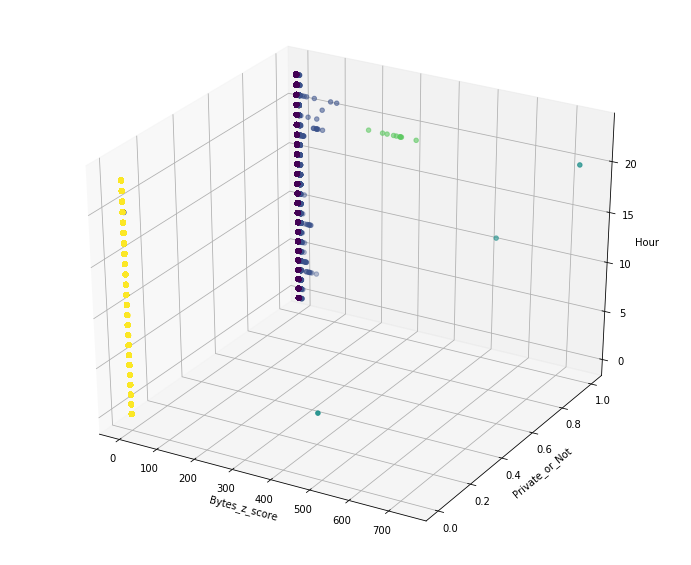

In [18]:
plt = plt.figure(figsize=(12,10)).gca(projection='3d')
plt.scatter(netflow_cluster_pd.z_score, netflow_cluster_pd.private, netflow_cluster_pd.hour, c=netflow_cluster_pd.kmeans_feat)
plt.set_xlabel('Bytes_z_score')
plt.set_ylabel('Private_or_Not')
plt.set_zlabel('Hour')
plt

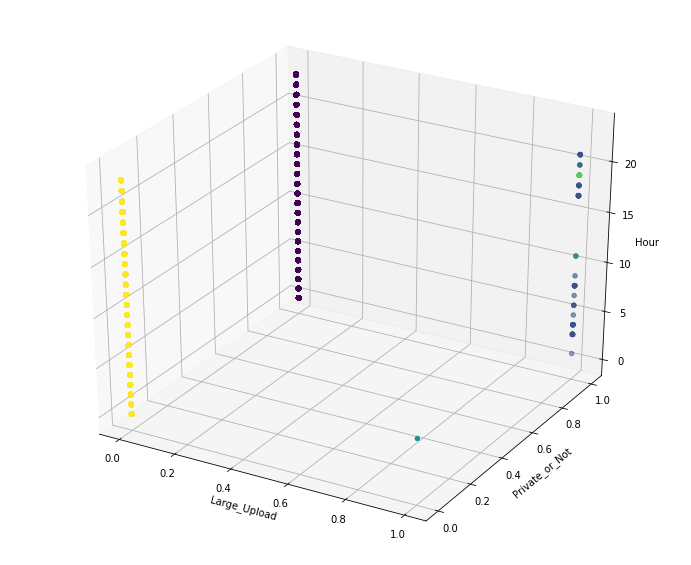

In [6]:
plt = plt.figure(figsize=(12,10)).gca(projection='3d')
plt.scatter(netflow_cluster_pd.large_upload, netflow_cluster_pd.private, netflow_cluster_pd.hour, c=netflow_cluster_pd.kmeans_feat)
plt.set_xlabel('Large_Upload')
plt.set_ylabel('Private_or_Not')
plt.set_zlabel('Hour')
plt

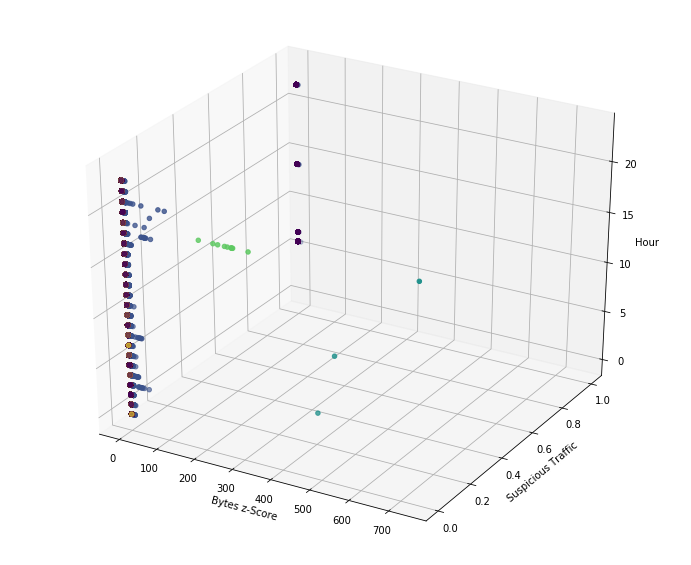

In [8]:
plt = plt.figure(figsize=(12,10)).gca(projection='3d')
plt.scatter(netflow_cluster_pd.z_score, netflow_cluster_pd.suspicious_traffic, netflow_cluster_pd.hour, c=netflow_cluster_pd.kmeans_feat)
plt.set_xlabel('Bytes z-Score')
plt.set_ylabel('Suspicious Traffic')
plt.set_zlabel('Hour')
plt

### Label the Dataset

In [4]:
#read in the netflow data
netflow_cluster = spark.read.csv('netflow_cluster.csv', header=True, inferSchema=True)

In [7]:
netflow_labeled.dtypes

[('_c0', 'int'),
 ('dest_ip', 'string'),
 ('dest_port', 'int'),
 ('src_ip', 'string'),
 ('src_port', 'int'),
 ('app', 'string'),
 ('bytes', 'bigint'),
 ('bytes_in', 'int'),
 ('bytes_out', 'int'),
 ('timestamp', 'timestamp'),
 ('endtime', 'timestamp'),
 ('z_score', 'double'),
 ('z_score_class', 'int'),
 ('large_upload', 'int'),
 ('tor_class', 'int'),
 ('private', 'double'),
 ('date', 'timestamp'),
 ('hour', 'int'),
 ('second', 'int'),
 ('bad_traffic', 'int'),
 ('suspicious_traffic', 'int'),
 ('kmeans_feat', 'int'),
 ('anomalous', 'int')]

In [28]:
netflow_labeled = netflow_cluster_pd.select(col("*"), fn.expr("case when z_score_class == 1 OR large_upload == 1 OR tor_class == 1 OR bad_traffic == 1 OR kmeans_feat == 2 OR kmeans_feat == 3 OR kmeans_feat == 4 then 1 else 0 end").alias("anomalous"))
netflow_labeled.where('anomalous == 1').count()

6234

In [29]:
netflow_labeled = netflow_labeled.drop('z_score','z_score_class','large_upload','tor_class','private','bad_traffic', 'suspicious_traffic','features','kmeans_feat')

In [30]:
netflow_labeled.where('anomalous == 1').count()

6234

In [31]:
netflow_labeled.show()

+---------------+---------+--------------+--------+----------+-------+--------+---------+--------------------+--------------------+-------------------+----+------+---------+
|        dest_ip|dest_port|        src_ip|src_port|       app|  bytes|bytes_in|bytes_out|           timestamp|             endtime|               date|hour|second|anomalous|
+---------------+---------+--------------+--------+----------+-------+--------+---------+--------------------+--------------------+-------------------+----+------+---------+
|   40.97.128.34|      443|    10.0.2.109|   58107| office365|1441608|  167497|  1274111|2017-07-31 14:46:...|2017-08-01 01:09:...|2017-07-31 00:00:00|  14|    43|        0|
|   40.97.128.34|      443|    10.0.2.109|   58107| office365|1441608|  167497|  1274111|2017-07-31 21:46:...|2017-08-01 08:09:...|2017-07-31 00:00:00|  21|    43|        0|
|   40.97.128.34|      443|    10.0.2.109|   58107| office365|1441608|  167497|  1274111|2017-07-31 22:46:...|2017-08-01 09:09:...

In [64]:
(netflow_labeled.where('suspicious == 1').count() / netflow_labeled.count())* 100

0.3060405452175642

In [33]:
netflow_labeled.toPandas().to_csv('netflow_labeled.csv')

# PCA for Netflow Logs

# Logistic Regression of netflow logs

# Network X Graph Analysis